# Compute distance and geodesic between meshes

This notebook shows how `geomstats` can be used to compute distances and geodesics between already-registered meshes using an elastic metric.

It downloads meshes from [figshare](https://figshare.com/articles/dataset/pregnancy-data/28339535), uses [pyvista](https://docs.pyvista.org/) for visualization, and [geomstats](https://geomstats.github.io/) for computing distances and geodesics.

In [1]:
import os

os.environ["GEOMSTATS_BACKEND"] = "pytorch"

In [2]:
import pyvista as pv

import geomstats.backend as gs
from geomstats.geometry.discrete_surfaces import DiscreteSurfaces, ElasticMetric

from polpo.preprocessing import Map, Sorter, Truncater
from polpo.preprocessing.load import FigsharePregnancyDataLoader
from polpo.preprocessing.mesh.io import TrimeshReader
from polpo.preprocessing.mesh.conversion import TrimeshToData, PvFromData
from polpo.preprocessing.path import FileFinder, FileRule

[KeOps] Warning : cuda was detected, but driver API could not be initialized. Switching to cpu only.


In [3]:
STATIC_VIZ = True

if STATIC_VIZ:
    pv.set_jupyter_backend("static")

Let's download some already-registered mesh data (see e.g. [this](https://geometric-intelligence.github.io/polpo/_notebooks/how_to/mesh/mesh_viz_compare.html) for more details.)

In [4]:
loader = (
    FigsharePregnancyDataLoader(
        data_dir="~/.herbrain/data/pregnancy/registration",
        remote_path="registration/elastic_20250105_90",
    )
    + FileFinder(
        rules=[
            FileRule(value="left_", func="startswith"),
            FileRule(value=".ply", func="endswith"),
        ],
    )
    + Sorter()
    + Truncater(value=2)
    + Map([TrimeshReader(), TrimeshToData()])
)

registered_meshes = loader()

INFO: Data has already been downloaded... using cached file ('/home/luisfpereira/.herbrain/data/pregnancy/registration/elastic_20250105_90').


In [5]:
to_pv = Map(PvFromData(), force_iter=True)

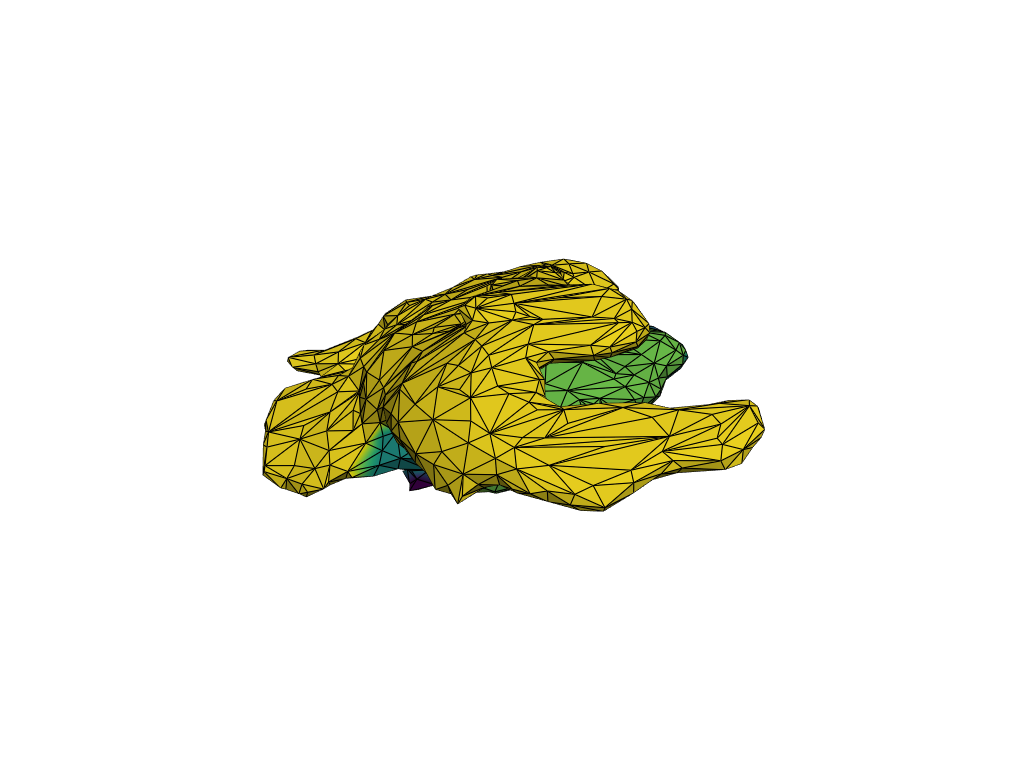

In [6]:
index = 0

pl = pv.Plotter(border=False)

pl.subplot(0, 0)
pl.add_mesh(to_pv(registered_meshes[0]), show_edges=True)
pl.remove_scalar_bar()

pl.show()

Compute distances between meshes.

NB: meshes were loaded as `numpy` arrays, which need to be converted to `torch` tensors.

In [7]:
faces = gs.from_numpy(registered_meshes[0][1])

vertices = gs.stack([gs.from_numpy(mesh[0]) for mesh in registered_meshes])

In [8]:
space = DiscreteSurfaces(faces, equip=False).equip_with_metric(
    ElasticMetric,
    a0=0.01,
    a1=10.0,
    b1=10.0,
    c1=1.0,
    d1=0.0,
    a2=1.0,
)

In [9]:
space.metric.squared_dist(vertices[0], vertices[1])

tensor(719.9718)

Compute and plot geodesics.

In [10]:
geod = space.metric.geodesic(vertices[0], end_point=vertices[1])

In [11]:
to_pv_from_torch = lambda vertices: to_pv((gs.to_numpy(vertices), gs.to_numpy(faces)))

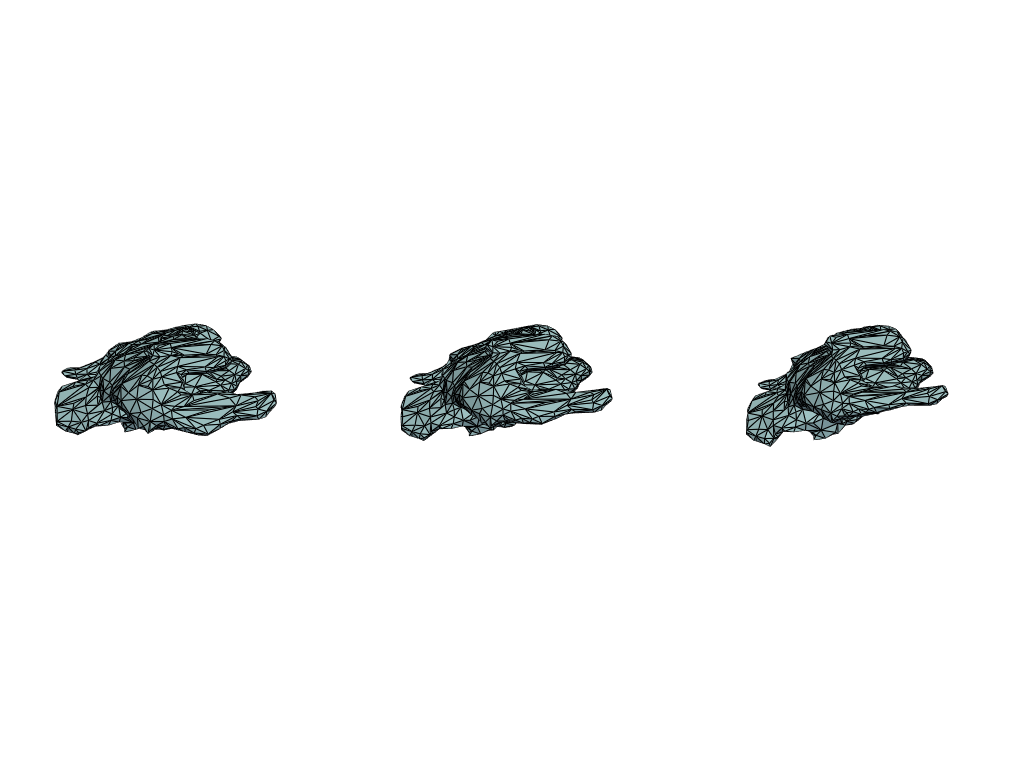

In [12]:
pl = pv.Plotter(shape=(1, 3), border=False)

pl.subplot(0, 0)
pl.add_mesh(to_pv_from_torch(geod(0.0)[0]), show_edges=True)

pl.subplot(0, 1)
pl.add_mesh(to_pv_from_torch(geod(0.5)[0]), show_edges=True)

pl.subplot(0, 2)
pl.add_mesh(to_pv_from_torch(geod(1.0)[0]), show_edges=True)

pl.link_views()

pl.show()